# Introduction to MCMC


## Takeaways and objectives from this notebook
1. The concept of Gibbs sampling using full conditional distributions. When is Gibbs sampling suitable?
2. Combining Gibbs and Metropolis: Metropolis-within-Gibbs.

## Gibbs sampling
So-far we have seen the Metropolis algorithm as the workhorse of sampling from a posterior distribution.  Another method of accomplishing the same is Gibbs sampling, which rests on different justifications and has different properties.

Gibbs sampling is the method of sampling from *full conditional posteriors*, so we need to compute the conditional distribution of each variable given the others and sample from that.

The algorithm for round robin Gibbs assuming that our state vector has $n$ variables $\mathbf{x}^{(t)} = [x_1^{(t)}, x_2^{(t)}, ..., x_n^{(t)}]$, the Gibbs sampler proceeds to sample $\mathbf{x}^{(t+1)}$ as follows:

1. Sample $x_1^{(t+1)}$ from $p(x_1^{(t+1)} \mid x_2^{(t)}, ..., x_n^{(t)})$,
2. Sample $x_2^{(t+1)}$ from $p(x_2^{(t+1)} \mid x_1^{(t+1)}, x_2^{(t)}, ..., x_n^{(t)})$
3. ...
4. Sample $x_i^{(t+1)}$ from $p(x_i^{(t+1)} \mid x_1^{(t+1)}, ..., x_{i-1}^{(t+1)}, x_{i+1}^{(t)}, ..., x_n^{(t)})$
5. ...
6. Sample $x_n^{(t+1)}$ from $p(x_n^{(t+1)} \mid x_2^{(t+1)}, ..., x_{n-1}^{(t+1)}$.

We then set $\mathbf{x}^{(t+1)} = [x_1^{(t+1)}, ..., x_{n-1}^{(t+1)}]$, as expected. So theoretically the algorithm is very simple.  Programmatically we can think of the algorithm as going through the variables from first to last and updating them in-place.  On the $i$-th variable, we simply use all the updated values for variables $0..i-1$.

Alternatively, we can also use the *random scan Gibbs* sampling algorithm, which proceeds as follows:
1. Pick index $i$ uniformly at random from $1,...,n$,
2. Sample $x_i^{(t+1)}$ from $p(x_i^{(t+1)} \mid x_1^{(t+1)}, ..., x_{i-1}^{(t+1)}, x_{i+1}^{(t)}, ..., x_n^{(t)}),$
3. Set $\mathbf{x}^{(t+1)} = [x_1^{(t)}, ..., x_i^{(t+1)},... x_{n-1}^{(t)}].$

*Blocked Gibbs sampling* treats some groups of variables in blocks and samples an update to them at the same time.  This is useful for example if that group of variables is highly correlated.  Considering them separately would then result in missing this structure. We will not consider blocking in this notebook.

Good introductory reading on Gibbs sampling is for example in Casella and George [2].

All of the above procedures correspond to valid Gibbs sampling algorithms, so there is considerable flexibility in the design.

### A summary and comparison: Metropolis vs. Gibbs
A (biased) summary of the differences between Metropolis and Gibbs sampling could go as follows.  While deriving a Gibbs sampler is more work, as a result the Gibbs sampler actually has better guidance in selecting new values for random variables.  Where Metropolis performs blind guesses and relies on the accept/reject step to check if the step is good, the Gibbs sampler samples directly from the conditional distribution and thus is guided in it's choice of next value by both the data and prior (as applicable to the current random variable).

We can also see [Gibbs sampling as a Metropolis-type proposal](https://en.wikipedia.org/wiki/Gibbs_sampling#Introduction) (but in a more general incarnation Metropolis-Hastings) which is always accepted.  There are some interesting connections between Gibbs and Metropolis that allow embedding one in the other, which will become useful later on.

### How to select a strategy?

It is a natural question whether some of these strategies are better than others.  It's difficult to find information on these topics but the following considerations seem useful.

**Blocked sampler** If some variables are highly correlated it makes sense to sample them together given the other variables. Thus if we imagine trying to use the Gibbs sampler on the 2D Gaussian with high correlation we have used previously, we see that being able to incorporate the correlation into the proposal would allow us to move diagonally instead of axis-aligned (per variable).

**Random/systematic scan** there don't seem to be results preferring one or the other except for Andrieu 2016 [3] (!!), where it is shown that systematic scan is better than random scan in terms of reducing the variance of the estimator **if** the problem consists of two variables and discusses why the proof does not hold for more variables then that.

### Example: Ising model
A very popular example for the Gibbs algorithm is the [Ising model](https://en.wikipedia.org/wiki/Ising_model) which can be observed live for example on [this page](https://cs.stanford.edu/people/karpathy/visml/ising_example.html) [1].

A simple version of an Ising model is a two-dimensional lattice of binary variables $x_i \in \{-1,+1\}$ that are horizontally and vertically connected using pairwise factor potentials.  

![Ising model](https://jgtechnologysolutions.files.wordpress.com/2017/02/ising.png?w=620)
Image source: https://jgtechnologysolutions.org

We may also apply a potential field $\bf{b}$, which attract some elements of the Ising model toward 1 or toward -1.  The total *energy* of the field is given by the Hamiltonian and can then be written as:

$$H(\textbf{x}) = - J \sum_{(i,j) \in E} x_i x_j - J_b \sum_{i \in V} b_i x_i,$$

where $J$ is the strength of the interactions, $J_b$ is the strength of the external field and $b_i$ are the desired values. The first sum is over edges $E$ connecting the elements (see figure below) and the other is over the elements $V$ themselves.

We define the (unnormalized) distribution over states to be:

$$\pi(\textbf{x}) = \exp (- H(\textbf{x}))$$

The $\pi(x)$ distribution is our posterior that we wish to sample from (we didn't explictly build any priors or data likelihood - let's assume that the function above is the result of such considerations). Let's break down how the probability depends on a value of a fixed element $x_i$.

Hence forth we will denote $E_i(x_i)$ as the part of the energy $E$ that depends on $x_i$ and $E_{-i}$ as the rest of the function. In Gibbs sampling we select one (or more) variables that we want to update and the rest of the model (here represented by $E_{-i}$ remains unchanged. For concreteness, we only select a single variable to update here. Note that $E = E_i(x_i) + E_{-i}$.

For the purposes of analyzing the update, we will denote the neighbouring nodes $x_a, x_b, x_c, x_d$.

For Gibbs sampling, we need to compute $\pi(x_i \mid x_{-i})$ which can be computed as

$$ \pi(x_i = v \mid x_{-i}) = \frac{\pi(x_i=v \mid x_{-i})}{\pi(x_i=+1 \mid x_{-i}) + \pi(x_i=-1 \mid x_{-i})}.$$

Where $v \in \{ -1, +1 \}$.

**Note** that here we casually sidestep the normalization problem. Normalization is intractable for the entire model $\pi(x)$ but since here we restricted our analysis only to one variable, it's easy and is solved by the formula above, which returns a valid conditional distribution $\pi(x_i = v \mid x_{-i})$ even if $\pi(x)$ is not normalized.

These considerations lead us to consider $E_i(x_i)$ and $E_{-1}$.  Rewriting the equation in logs again, we get

$$ \pi(x_i = +1 \mid x_{-i}) = \frac{\exp(E_i(x_i=+1) + E_{-i})}{\exp(E_i(x_i=+1)+E_{-i}) + \exp(E_i(x_i=+1)+E_{-i}) }$$

from which we can factor and cancel out $E_{-i}$ to obtain

$$ \pi(x_i = +1 \mid x_{-i}) = \frac{\exp(E_i(x_i=+1))}{\exp(E_i(x_i=+1)) + \exp(E_i(x_i=-1))}.$$

**Note** that this results in a huge computational efficiency gain, we can evaluate the conditional with respect to only the neighbouring nodes as the state of $x_i$ is conditionally independent from the rest of the model given it's neighbors.  In effect, we can compute the posterior in O(1) time and update the entire state in $O(N)$ time where $N$ is the number of elements.

We thus have

$$E_i(x_i) = J(x_ix_a + x_ix_b + x_ix_c + x_ix_d) + J_bb_ix_i,$$

which factorizes nicely

$$E_i(x_i) = x_i \left ( J (x_a + x_b + x_c + x_d) + J_bb_i \right ),$$

which makes the value extremely simple to compute for both options $x_i=+1$ and $x_i=-1$.


## Setting it up
Below we build the force field that will act on the system, a random state generator and a function that computes the Hamiltonian for us.

In [1]:
import numpy as np
import numpy.random as nr

# rows and columns
rows, cols = 8, 8

b = np.array([[-1, -1, -1, -1, -1, -1, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1],
              [-1, -1, +1, -1, +1, +1, -1, -1],
              [-1, -1, +1, +1, +1, +1, -1, -1],
              [-1, -1, +1, -1, +1, -1, -1, -1],
              [-1, -1, +1, +1, +1, +1, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1]])

In [2]:
def random_state(prob_one):
    X = np.where(nr.uniform(size=(8,8)) < 1. - prob_one, -1, +1)
    return X

X_init = random_state(0.5)
X_init

array([[ 1, -1,  1, -1,  1, -1,  1,  1],
       [ 1,  1,  1, -1, -1,  1, -1,  1],
       [-1, -1, -1, -1,  1, -1,  1, -1],
       [ 1,  1, -1, -1,  1, -1, -1, -1],
       [-1,  1,  1, -1, -1,  1, -1,  1],
       [ 1, -1, -1,  1,  1, -1, -1,  1],
       [ 1,  1, -1,  1, -1,  1,  1,  1],
       [ 1, -1, -1, -1, -1,  1,  1, -1]])

In [3]:
def compute_hamiltonian(X, b, J, Jb):
    H = 0.0
    
    for r in range(rows):
        for c in range(cols):
            # evaluate the E_i term for the actual value of X[r,c]
            # sum over elements
            H -= Jb * b[r,c] * X[r,c]
            
            # sum over edges
            if r > 0:
                H -= J * X[r-1,c] * X[r,c]
            if c > 0:
                H -= J * X[r, c-1] * X[r,c]
    return H

In [4]:
H = compute_hamiltonian(X_init, b, 1., 1.)
pi = np.exp(-H)
H, pi

(24.0, 3.775134544279098e-11)

### Exercise: derive the full conditional
A key part of developing the Gibbs sampler is the function that computes the conditional distribution of $x_i$ given $x_{-i}$, or given all the other states.  In the following, write the function that computes this efficiently.  We supply a function that computes the value by definition but has terrible time complexity.

To derive the more effective function, analyze how a change in the value of $x_i$ affects the posterior and what remains unchanged.  Only that part must be evaluated.

In [5]:
def compute_conditional_xrc_is_minus1_slow(X,b,r,c,J,Jb):
    memory = X[r,c]
    # compute conditional from definition
    X[r,c] = +1.
    pi_x_plus1 = np.exp(-compute_hamiltonian(X, b, J, Jb))
    
    X[r,c] = -1
    pi_x_minus1 = np.exp(-compute_hamiltonian(X, b, J, Jb))
    
    return pi_x_minus1 / (pi_x_minus1 + pi_x_plus1)

In [6]:
def compute_conditional_xrc_is_minus1(X,b,r,c,J,Jb):
    sum_xabcd = 0.0
    if c > 0:
        sum_xabcd += X[r,c-1]
    if c < cols-1:
        sum_xabcd += X[r,c+1]
    if r > 0:
        sum_xabcd += X[r-1,c]
    if r < rows-1:
        sum_xabcd += X[r+1,c]
        
    factor = - J * sum_xabcd - Jb * b[r,c]
    pi_i_xi_minus1 = np.exp(- (-1. * factor))
    pi_i_xi_plus1 = np.exp(- (+1. * factor))
    return pi_i_xi_minus1 / (pi_i_xi_minus1 + pi_i_xi_plus1)

#### Testing your function
The two functions below must give the same output given the same inputs.

In [7]:
compute_conditional_xrc_is_minus1(X_init, b, 2, 1, 1., 0.5), compute_conditional_xrc_is_minus1_slow(X_init,b,2,1,1.,0.5)

(0.731058578630005, 0.731058578630005)

### Let's run the sampler
The function `run_gibbs_systematic_scan` below performs systematic scan Gibbs sampling.  Using your function, run the sampler a few times and examine the visualizations to see what happens under various field and connection strengths.

In [8]:
def run_gibbs_systematic_scan(X, b, J, Jb, steps=1):
    # note that X is modified in place
    for s in range(steps):
        # pre-sample a bunch of uniform random numbers
        random_buffer = np.random.uniform(size=(rows, cols))
        for r in range(rows):
            for c in range(cols):
                cond_p_xi_minus1 = compute_conditional_xrc_is_minus1(X, b, r, c, J, Jb)
                X[r,c] = -1. if random_buffer[r,c] < cond_p_xi_minus1 else +1.

In [9]:
Xstate = np.copy(X_init)
run_gibbs_systematic_scan(Xstate, b, 1., 0.5)
Xstate

array([[-1,  1,  1,  1, -1,  1,  1,  1],
       [-1,  1, -1, -1, -1, -1,  1,  1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1, -1,  1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1]])

### Visualizing samples
Below we run the Gibbs sampler iteratively and display every second sample.

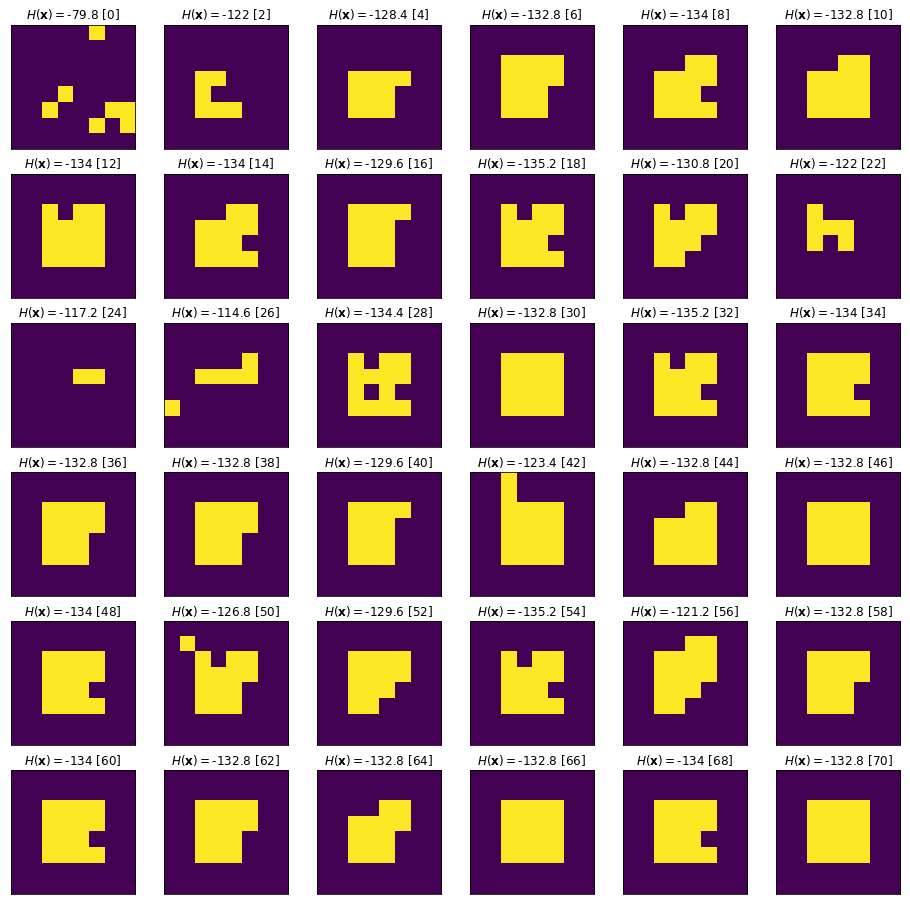

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

steps_per_iter = 2

plt.figure(figsize=(16,16))
Xstate = random_state(0.1)
for step in range(36):
    plt.subplot(6,6,step+1)
    plt.imshow(Xstate)
    plt.xticks([])
    plt.yticks([])
    plt.title('$H({\\bf x})=$%g [%d]' % (compute_hamiltonian(Xstate, b, 0.5, 1.6), step*steps_per_iter))
    run_gibbs_systematic_scan(Xstate, b, 0.8, 1.6, steps=steps_per_iter)

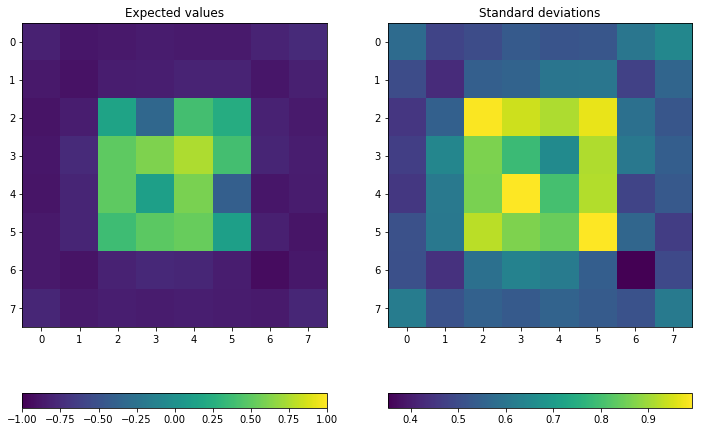

In [11]:
# let's generate 1000 samples
N = 1000
X = random_state(0.5)
Xs = np.zeros((N, rows, cols))
for i in range(N):
    # variable is modified in place
    run_gibbs_systematic_scan(X, b, 0.3, 0.6)
    Xs[i,:,:] = X

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(np.mean(Xs, axis=0))
plt.title('Expected values')
plt.colorbar(orientation='horizontal')
plt.clim([-1,1])
plt.subplot(1,2,2)
plt.imshow(np.std(Xs, axis=0))
plt.colorbar(orientation='horizontal')
plt.title('Standard deviations');

### Exercise
Build a `run_gibbs_random_scan` function to perform random scan Gibbs sampling, run it in place of `run_gibbs_systematic_scan` and observe whether there are any changes in the output.

## Metropolis-within-Gibbs
The Gibbs algorithm requires that we can derive and evaluate conditional probabilities for all variables.  This is impractical in many situations.  

In such cases, it's possible to to sample with a design called Metropolis-within-Gibbs, where we combine Gibbs and Metropolis sampling.  Extra reading on designing hybrid sampling systems is for example in Tierney [4].  Here we only note that there is significant flexibility in constructing hybrid samplers and the following is just one example.

Let's solve a simple mixture problem with two Gaussian mixtures that we want to fit a set of points $d_i, i=1,...,40$ in one dimension.

$$\begin{array}{rcl}
   \mu_0 &\sim& {\cal N}(0,10) \\
   \mu_1 &\sim& {\cal N}(0,10) \\
   Z_i &\sim& \text{Bernoulli}(0.5) \\
   d_i &\sim& {\cal N}(\mu_0(1-Z_i) + \mu_1 Z_i) \\
\end{array}$$

Writing a Metropolis sampler for this model should be a breeze, but this time we will do something different: write a hybrid sampler that uses different methods of proposing different variables:

- $\mu_0, \mu_1$ using Metropolis random walk (with accept/reject) and
- $Z$ using Gibbs sampling (always accepted).

If we cycle these two proposals, we have a valid hybrid sampler.

In [12]:
def generate_data(mu1, mu2, N):
    return np.hstack([nr.randn(N) + mu1, nr.randn(N) + mu2])

def log_normal(x, mu, sd):
    return - np.log(sd) - 0.5 * (x - mu)**2/sd**2

def log_prior(v):
    return log_normal(v['mu0'], 0, 10) + log_normal(v['mu0'], 0, 10) + len(v['Z']) * np.log(0.5)

def log_likelihood(v, data):
    Z = v['Z']
    return np.sum(log_normal(data, v['mu0'] * (1-Z) + v['mu1'] * Z, 1.0))

def log_posterior(v, data):
    # add a factor potential that forces v['mu0'] <= v['mu1']
    ordering_potential = -np.inf if v['mu0'] > v['mu1'] else 0.
    return log_prior(v) + log_likelihood(v, data) + ordering_potential

In [13]:
# Let's make the problem easy to visualize
N = 20
true_mu0, true_mu1 = 2.0, 6.0
data = generate_data(true_mu0, true_mu1, N)

In [14]:
import seaborn as sns

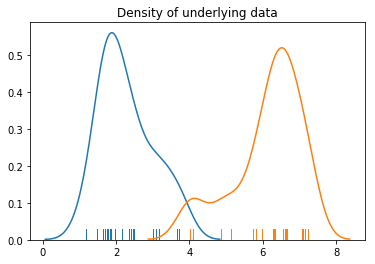

In [15]:
sns.distplot(data[:N], hist=False, rug=True)
sns.distplot(data[N:], hist=False, rug=True)
plt.title('Density of underlying data');

In [16]:
data

array([2.15348991, 2.36035185, 1.77691559, 2.49845557, 1.85089292,
       3.72435169, 1.82238938, 2.46466242, 1.1725064 , 3.17464464,
       1.63208048, 1.69499755, 3.00314943, 1.49244825, 3.66203201,
       1.87124391, 3.10025441, 1.96348128, 2.39675264, 1.75752666,
       7.14083822, 6.6738988 , 5.1350033 , 6.59538966, 6.66986584,
       4.10928892, 7.08233399, 7.23941758, 4.86248575, 6.34598557,
       5.73428378, 6.55657379, 6.2700873 , 6.28871947, 6.30215067,
       7.10573491, 5.81720769, 5.9811001 , 6.6295138 , 4.01156953])

In [30]:
v_init = {
    'mu0': nr.randn() * 5,
    'mu1': nr.randn() * 5,
    'Z' : np.where(nr.rand(2*N) < 0.5, 0, 1)
}

# ensure ordering holds
if v_init['mu1'] < v_init['mu0']:
    v_init['mu0'], v_init['mu1'] = v_init['mu1'], v_init['mu0']

v_init, log_posterior(v_init, data)

({'mu0': 2.3118538437151903,
  'mu1': 2.8408719672834426,
  'Z': array([0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
         0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1])},
 -166.24314729380458)

In [31]:
log_prior(v_init), log_likelihood(v_init, data)

(-32.38450409033291, -133.85864320347167)

In [32]:
def plot_state(v):
    global data
    Z=v['Z']    
    plt.plot([v['mu0']], [0.1], 'go')
    plt.plot([v['mu1']], [0.1], 'ro')
    sns.distplot(data[Z==0], hist=False, rug=True)
    sns.distplot(data[Z==1], hist=False, rug=True)

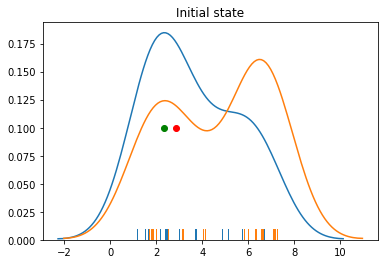

In [33]:
plot_state(v_init)
plt.title('Initial state');

In [34]:
def propose_mus(v, logp):
    v_prime = { 'mu0' : v['mu0'] + nr.randn() * 0.4,
                'mu1' : v['mu1'] + nr.randn() * 0.4,
                'Z' : v['Z']
              }
    
    logp_prime = log_posterior(v_prime, data)
    if logp_prime - logp > np.log(nr.rand()):
        return v_prime, logp_prime, True
    else:
        return v, logp, False
    
    
def propose_Z_metropolis(v, logp):    
    Z = v['Z']
    flips = nr.uniform(size=Z.shape) < 0.1
    Z_prime = flips * (1-Z) + (1-flips)*Z
    
    v_prime = {
        'mu0' : v['mu0'],
        'mu1' : v['mu1'],
        'Z' : Z_prime
    }

    logp_prime = log_posterior(v_prime, data)
    if logp_prime - logp > np.log(nr.rand()):
        return v_prime, logp_prime, True
    else:
        return v, logp, False
        

def propose_Z_gibbs(v, logp):
    mu0, mu1, Z = v['mu0'], v['mu1'], v['Z']
    Z0s = log_normal(data, mu0, 1.0)
    Z1s = log_normal(data, mu1, 1.0)
    Zmax = np.amax(np.vstack([Z0s, Z1s]), axis=0)
        
    # the logsumexp operation normalizes the posterior in a numerically stable way while always remaining in log space
    C_hats = Zmax + np.log(np.exp(Z0s - Zmax) + np.exp(Z1s - Zmax))
    Znew = np.where(np.log(nr.uniform(size=Z.shape)) < Z0s - C_hats, 0, 1)
    
    v_prime = {
        'mu0' : v['mu0'],
        'mu1' : v['mu1'],
        'Z' : Znew
    }
    
    return v_prime, log_posterior(v_prime, data)

### Exercise

The sampler below uses two Metropolis steps in sequence to sample from the $\mu_{0,1}$ and from $Z$.  There is a block that is commented out with the function `propose_Z_gibbs` that you should uncomment (after writing the function that is).

1. Compare the number of steps required for convergence using Metropolis and using the hybrid sampler. The number of samples is intentionally set to a low number (100) to display the differences.
2. Run the `propose_Z_gibbs` function a few times yourself while printing out the state and note that the proposed `Z` values match the data very well compared to the random guesses in `propose_Z_metropolis`.

In [35]:
def metropolis_within_gibbs(v_init, n, status_period = None):
    global data
    
    v, logp = v_init, log_posterior(v_init, data)
    states, states_logp = [v_init], [logp]
    was_accept1, was_accept2 = [], []
    
    if status_period is None:
        status_period = n // 10
    
    for i in range(1,n):
                
        # propose mu1 and mu2 via a Metropolis step
        v1, logp_v1, accept1 = propose_mus(v, logp)
        was_accept1.append(accept1)

        # EXERCISE: the two blocks below sample Z, currently we have an inefficient Metropolis sampler,
        # but we would like to have a sleek Gibbs sampler - uncomment the gibbs block below and comment
        # the Metropolis block when you have your Gibbs proposal.
        
        # now v1, logp_v1 are either v, logp if a reject occured or a new state
        #v2, logp_v2, accept2 = propose_Z_metropolis(v1, logp_v1)
        #was_accept2.append(accept2)
        
        v2, logp_v2 = propose_Z_gibbs(v1, logp_v1)
        was_accept2.append(True)
        
        # append whatever came out
        states.append(v2)
        states_logp.append(logp_v2)
        
        v, logp = v2, logp_v2
            
        if i > 1 and i % status_period == 0:
            print('Stats @ %d: accept1_ratio=%g accept2_ratio=%g avg_logp=%g' %
                  (i, float(np.sum(was_accept1[-status_period:]))/status_period,
                   float(np.sum(was_accept2[-status_period:]))/status_period,
                   np.mean(states_logp[-status_period:])))
            
    return states, float(np.sum(was_accept1)) / n, float(np.sum(was_accept2)) / n

In [36]:
states, ar1, ar2 = metropolis_within_gibbs(v_init, 100, status_period=10)

Stats @ 10: accept1_ratio=0.3 accept2_ratio=1 avg_logp=-146.322
Stats @ 20: accept1_ratio=0.2 accept2_ratio=1 avg_logp=-138.569
Stats @ 30: accept1_ratio=0.4 accept2_ratio=1 avg_logp=-117.438
Stats @ 40: accept1_ratio=0.5 accept2_ratio=1 avg_logp=-56.3573
Stats @ 50: accept1_ratio=0.4 accept2_ratio=1 avg_logp=-47.9419
Stats @ 60: accept1_ratio=0.5 accept2_ratio=1 avg_logp=-45.6391
Stats @ 70: accept1_ratio=0.2 accept2_ratio=1 avg_logp=-46.1957
Stats @ 80: accept1_ratio=0.3 accept2_ratio=1 avg_logp=-47.1725
Stats @ 90: accept1_ratio=0.3 accept2_ratio=1 avg_logp=-47.5733


In [37]:
mu0s = np.array([s['mu0'] for s in states])
mu1s = np.array([s['mu1'] for s in states])
Zs = np.vstack([s['Z'] for s in states])

burn_in = 0

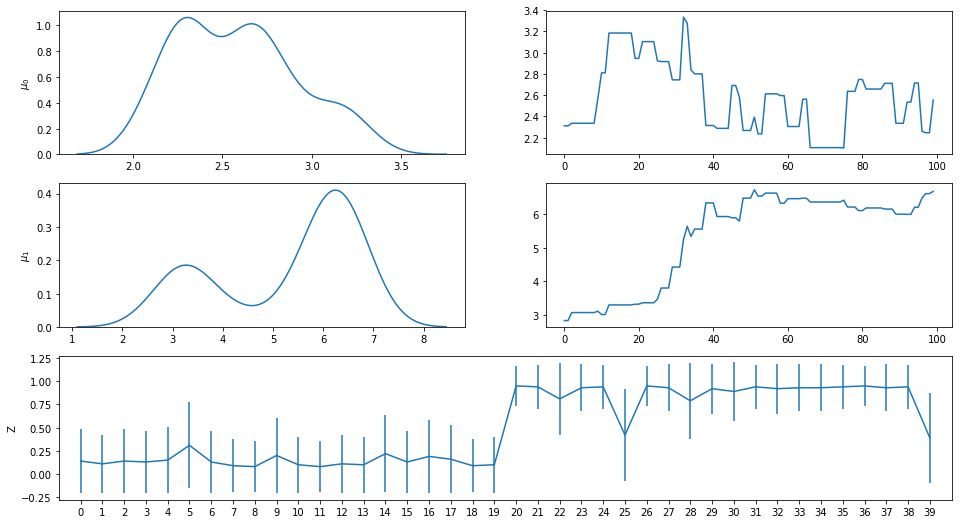

In [38]:
import seaborn as sns

plt.figure(figsize=(16,9))
plt.subplot(3,2,1)
sns.kdeplot(mu0s[burn_in:]);
plt.ylabel('$\\mu_0$')
plt.subplot(3,2,2)
plt.plot(mu0s)

plt.subplot(3,2,3)
sns.kdeplot(mu1s[burn_in:]);
plt.ylabel('$\\mu_1$')
plt.subplot(3,2,4)
plt.plot(mu1s)

plt.subplot(3,1,3)
plt.errorbar(np.arange(2*N), np.mean(Zs, axis=0), yerr=np.std(Zs, axis=0))
plt.xlim([-1,2*N])
plt.xticks(range(2*N))
plt.ylabel('Z');

In [39]:
# the following standard deviation calculation is wrong, since it doesn't take into account the correlation in the chain
# and assumes each value is independent.True standard deviations will be higher.
print('mu0: %g +- %g [true value: %g]' % (np.mean(mu0s[burn_in:]), np.std(mu0s[burn_in:]), true_mu0))
print('mu1: %g +- %g [true value: %g]' % (np.mean(mu1s[burn_in:]), np.std(mu1s[burn_in:]), true_mu1))

mu0: 2.57982 +- 0.328439 [true value: 2]
mu1: 5.29909 +- 1.37001 [true value: 6]


## Exercise [advanced]

For example in notebook 3g, while we can derive the conditional probability for the latent indicator variables $Z_{i,j}$ it is very difficult to derive the conditionals for the other variables.

Build a Metropolis-within-Gibbs scheme for the example in notebook 3g (build on your pure Metropolis solution) and note how the $Z$ variables that are sampled directly from the full conditional very nicely follow the likelihood.  Compare this strategy to the blind proposals in your Metropolis method.

## References

1. Andrej Karpathy, Stanford. [Ising model example](https://cs.stanford.edu/people/karpathy/visml/ising_example.html).
2. G Casella and G. Edwards, “Explaining the Gibbs sampler,” The American Statistician, 1992.
3. C Andrieu, “On random- and systematic-scan samplers,” Biometrika, vol. 103, no. 3, pp. 719–726, 2016.
4. L. Tierney, “Markov chains for exploring posterior distributions,” the Annals of Statistics, 1994.